In [1]:
!pip install tensorflow==2.18.0
!pip install tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html

Looking in links: https://storage.googleapis.com/libtpu-tf-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.3/234.3 MB 7.8 MB/s eta 0:00:00


Note: Running on CPU. bfloat16 will be emulated and may be slower than float32.


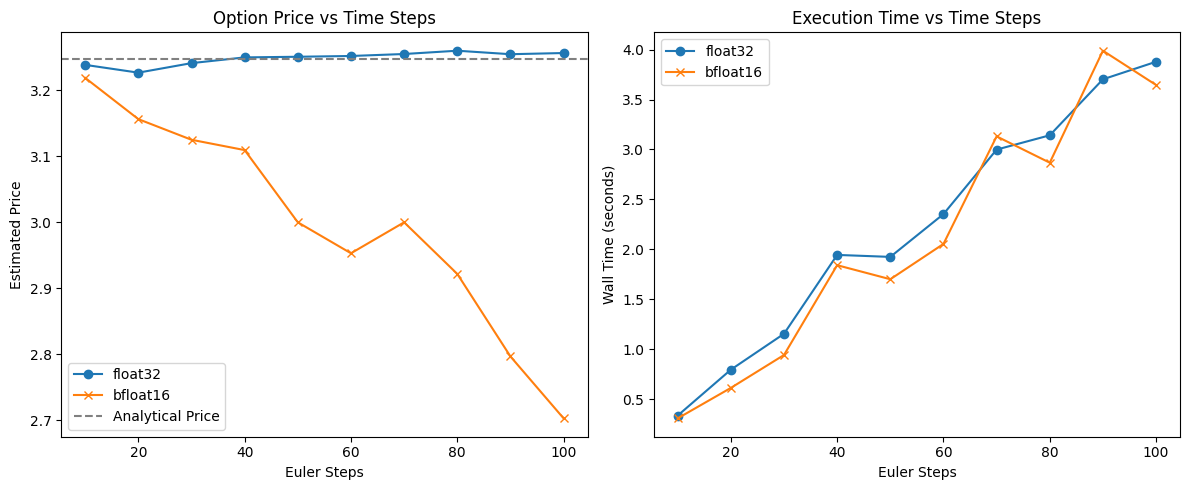

In [4]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import os

# TPU initialization
#os.environ['TPU_NAME'] = 'local'
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
#tf.config.experimental_connect_to_cluster(resolver)
#tf.tpu.experimental.initialize_tpu_system(resolver)
#strategy = tf.distribute.TPUStrategy(resolver)
#print("TPU devices:", tf.config.list_logical_devices('TPU'))

S0 = 100.0
K = 120.0
r = 0.05
sigma = 0.2
T = 1.0
n_paths = 1_000_000
steps_list = list(range(10, 110, 10))

print("Note: Running on CPU. bfloat16 will be emulated and may be slower than float32.")

# Monte Carlo function using stateless Threefry RNG
def bs_simulation(seed, shape_tensor, steps_tensor, dt_tensor, use_bfloat16=False):
    dtype = tf.bfloat16 if use_bfloat16 else tf.float32
    dt = tf.cast(dt_tensor, dtype)
    r_t = tf.constant(r, dtype=dtype)
    sigma_t = tf.constant(sigma, dtype=dtype)
    K_t = tf.constant(K, dtype=dtype)
    S0_t = tf.constant(S0, dtype=dtype)

    seeds = tf.stack([seed, seed + 1])
    dW = tf.random.stateless_normal(
        shape=shape_tensor,
        seed=seeds,
        mean=0.0,
        stddev=tf.cast(tf.sqrt(dt), dtype),
        dtype=dtype
    )

    S_paths = tf.ones((shape_tensor[0],), dtype=dtype) * S0_t
    for step in range(steps_tensor.numpy()):
        drift = (r_t - 0.5 * sigma_t**2) * dt
        diffusion = sigma_t * dW[:, step]
        S_paths *= tf.exp(drift + diffusion)

    payoff = tf.nn.relu(S_paths - K_t)
    discounted_payoff = tf.reduce_mean(payoff) * tf.exp(-r_t * tf.cast(T, dtype))
    return tf.cast(discounted_payoff, tf.float32)

def run_simulation(seed, steps, use_bfloat16):
    dt = T / steps
    shape = tf.constant([n_paths, steps], dtype=tf.int32)
    steps_tensor = tf.constant(steps, dtype=tf.int32)
    dt_tensor = tf.constant(dt, dtype=tf.float32)
    seed_tensor = tf.constant(seed, dtype=tf.int32)
    return bs_simulation(seed_tensor, shape, steps_tensor, dt_tensor, use_bfloat16)

prices_fp32, prices_bf16 = [], []
times_fp32, times_bf16 = [], []

for steps in steps_list:
    # float32
    start = time.time()
    price_fp32 = run_simulation(42, steps, False)
    prices_fp32.append(price_fp32.numpy())
    times_fp32.append(time.time() - start)

    # bfloat16
    start = time.time()
    price_bf16 = run_simulation(42, steps, True)
    prices_bf16.append(price_bf16.numpy())
    times_bf16.append(time.time() - start)

# Plotting Results
plt.figure(figsize=(12, 5))

# Estimated Price vs Steps
plt.subplot(1, 2, 1)
plt.plot(steps_list, prices_fp32, label="float32", marker='o')
plt.plot(steps_list, prices_bf16, label="bfloat16", marker='x')
plt.axhline(y=3.2475, color='gray', linestyle='--', label="Analytical Price")
plt.xlabel("Euler Steps")
plt.ylabel("Estimated Price")
plt.title("Option Price vs Time Steps")
plt.legend()

# Wall Time vs Steps
plt.subplot(1, 2, 2)
plt.plot(steps_list, times_fp32, label="float32", marker='o')
plt.plot(steps_list, times_bf16, label="bfloat16", marker='x')
plt.xlabel("Euler Steps")
plt.ylabel("Wall Time (seconds)")
plt.title("Execution Time vs Time Steps")
plt.legend()

plt.tight_layout()
plt.show()
